In [3]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from pydicom import dcmread
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm


import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils import data

(27204, 2)
(3023, 2)
patientId: 06cf339f-a71a-4177-b950-ae1fdd5f4762, Target: 1
27204
3023
Tensor: tensor([[[0.0745, 0.0784, 0.0784,  ..., 0.0745, 0.0784, 0.0824],
         [0.0745, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0784],
         [0.0706, 0.0667, 0.0667,  ..., 0.0706, 0.0706, 0.0745],
         ...,
         [0.3843, 0.4118, 0.4471,  ..., 0.5725, 0.5451, 0.5255],
         [0.3961, 0.4235, 0.4549,  ..., 0.5804, 0.5569, 0.5333],
         [0.4000, 0.4235, 0.4588,  ..., 0.5961, 0.5804, 0.5451]],

        [[0.0745, 0.0784, 0.0784,  ..., 0.0745, 0.0784, 0.0824],
         [0.0745, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0784],
         [0.0706, 0.0667, 0.0667,  ..., 0.0706, 0.0706, 0.0745],
         ...,
         [0.3843, 0.4118, 0.4471,  ..., 0.5725, 0.5451, 0.5255],
         [0.3961, 0.4235, 0.4549,  ..., 0.5804, 0.5569, 0.5333],
         [0.4000, 0.4235, 0.4588,  ..., 0.5961, 0.5804, 0.5451]],

        [[0.0745, 0.0784, 0.0784,  ..., 0.0745, 0.0784, 0.0824],
         [0.0745, 0.0706

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

213it [14:43,  4.15s/it]
  0%|          | 0/24 [00:00<?, ?it/s]

Epoch: 1/1, Val_Acc: 80.87992095947266


100%|██████████| 24/24 [01:27<00:00,  3.66s/it]


Val_Acc: 80.97915649414062


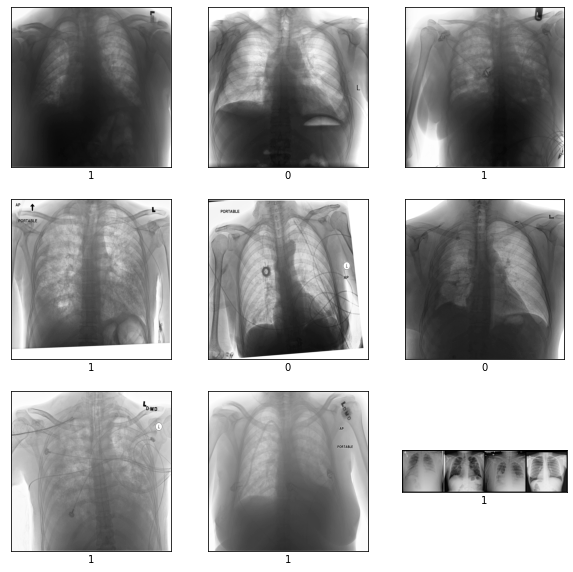

In [1]:
label_data = pd.read_csv('../input/rsna-pneumonia-detection-challenge/stage_2_train_labels.csv')
columns = ['patientId', 'Target']

label_data = label_data.filter(columns)
label_data.head(5)

train_labels, val_labels = train_test_split(label_data.values, test_size=0.1)
print(train_labels.shape)
print(val_labels.shape)
print(f'patientId: {train_labels[0][0]}, Target: {train_labels[0][1]}')

train_f = '../input/rsna-pneumonia-detection-challenge/stage_2_train_images'
test_f = '../input/rsna-pneumonia-detection-challenge/stage_2_test_images'

train_paths = [os.path.join(train_f, image[0]) for image in train_labels]
val_paths = [os.path.join(train_f, image[0]) for image in val_labels]

print(len(train_paths))
print(len(val_paths))

def imshow(num_to_show=9):
    plt.figure(figsize=(10, 10))
    
    for i in range(num_to_show):
        plt.subplot(3, 3, i+1)
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
        
        img_dcm = dcmread(f'{train_paths[i+20]}.dcm')
        img_np = img_dcm.pixel_array
        plt.imshow(img_np, cmap=plt.cm.binary)
        plt.xlabel(train_labels[i+20][1])

imshow()

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.Resize(224),
    transforms.ToTensor()
])

class Dataset(data.Dataset):
    def __init__(self, paths, labels, transform=None):
        self.paths = paths
        self.labels = labels
        self.transform = transform
    
    def __getitem__(self, index):
        image = dcmread(f'{self.paths[index]}.dcm')
        image = image.pixel_array
        image = image / 255.0
        image = (255*image).clip(0, 255).astype(np.uint8)
        image = Image.fromarray(image).convert('RGB')
        label = self.labels[index][1]
        
        if self.transform is not None:
            image = self.transform(image)
            
        return image, label
    
    def __len__(self):
        return len(self.paths)

train_dataset = Dataset(train_paths, train_labels, transform=transform)
image = iter(train_dataset)
img, label = next(image)
print(f'Tensor: {img}, Label: {label}')
img = np.transpose(img, (1, 2, 0))
plt.imshow(img)
img.shape

train_dataset = Dataset(train_paths, train_labels, transform=transform)
val_dataset = Dataset(val_paths, val_labels, transform=transform)

train_loader = data.DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)
val_loader = data.DataLoader(dataset=val_dataset, batch_size=128, shuffle=False)

batch = iter(train_loader)
images, labels = next(batch)
image_grid = torchvision.utils.make_grid(images[:4])
image_np = image_grid.numpy()
img = np.transpose(image_np, (1, 2, 0))
plt.imshow(img)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = torchvision.models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

num_epochs = 1  # Changed to 3 epochs

# Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
    # Training step
    for i, (images, labels) in tqdm(enumerate(train_loader)):
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 2000 == 0:
            print("Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}"
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

    # Validation step
    correct = 0
    total = 0  
    for images, labels in tqdm(val_loader):
        images = images.to(device)
        labels = labels.to(device)
        predictions = model(images)
        _, predicted = torch.max(predictions, 1)
        total += labels.size(0)
        correct += (labels == predicted).sum()
    print(f'Epoch: {epoch+1}/{num_epochs}, Val_Acc: {100*correct/total}')

model.eval()

correct = 0
total = 0  
for images, labels in tqdm(val_loader):
    images = images.to(device)
    labels = labels.to(device)
    predictions = model(images)
    _, predicted = torch.max(predictions, 1)
    total += labels.size(0)
    correct += (labels == predicted).sum()
print(f'Val_Acc: {100*correct/total}')


In [4]:
from pydicom import dcmread
from PIL import Image
import torchvision.transforms as transforms

# Define the path to the test image
test_image_path = '/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_images/000db696-cf54-4385-b10b-6b16fbb3f985.dcm'

# Define the image transformation
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor()
])

# Load and preprocess the test image
test_image = dcmread(test_image_path).pixel_array
test_image = (test_image / 255.0 * 255).clip(0, 255).astype(np.uint8)
test_image = Image.fromarray(test_image).convert('RGB')
test_image = transform(test_image).unsqueeze(0)

# Move the image to the appropriate device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
test_image = test_image.to(device)

# Set the model to evaluation mode
model.eval()

# Perform prediction on the test image
with torch.no_grad():
    prediction = model(test_image)

# Get the predicted class label
_, predicted_label = torch.max(prediction, 1)

# Print the predicted label
print(f'Predicted Label: {predicted_label.item()}')


Predicted Label: 0


In [2]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from pydicom import dcmread
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils import data

label_data = pd.read_csv('../input/rsna-pneumonia-detection-challenge/stage_2_train_labels.csv')
label_data = label_data[['patientId', 'Target']]

train_labels, val_labels = train_test_split(label_data.values, test_size=0.1)

train_paths = [os.path.join('../input/rsna-pneumonia-detection-challenge/stage_2_train_images', image[0]) for image in train_labels]
val_paths = [os.path.join('../input/rsna-pneumonia-detection-challenge/stage_2_train_images', image[0]) for image in val_labels]

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.Resize(224),
    transforms.ToTensor()
])

class Dataset(data.Dataset):
    def __init__(self, paths, labels, transform=None):
        self.paths = paths
        self.labels = labels
        self.transform = transform

    def __getitem__(self, index):
        image = dcmread(f'{self.paths[index]}.dcm').pixel_array
        image = Image.fromarray((image / 255.0 * 255).clip(0, 255).astype(np.uint8)).convert('RGB')
        label = self.labels[index][1]
        
        if self.transform is not None:
            image = self.transform(image)
            
        return image, label
    
    def __len__(self):
        return len(self.paths)

train_dataset = Dataset(train_paths, train_labels, transform=transform)
val_dataset = Dataset(val_paths, val_labels, transform=transform)

train_loader = data.DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)
val_loader = data.DataLoader(dataset=val_dataset, batch_size=128, shuffle=False)

model = torchvision.models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

num_epochs = 1

for epoch in range(num_epochs):
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    correct = 0
    total = 0
    for images, labels in tqdm(val_loader):
        images, labels = images.to(device), labels.to(device)
        predictions = model(images)
        _, predicted = torch.max(predictions, 1)
        total += labels.size(0)
        correct += (labels == predicted).sum()
        
    print(f'Epoch: {epoch+1}/{num_epochs}, Val_Acc: {100*correct/total}')

model.eval()

test_image_path = '/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_images/000db696-cf54-4385-b10b-6b16fbb3f985.dcm'
test_image = Image.fromarray((dcmread(test_image_path).pixel_array / 255.0 * 255).clip(0, 255).astype(np.uint8)).convert('RGB')
test_image = transform(test_image).unsqueeze(0).to(device)

with torch.no_grad():
    prediction = model(test_image)

_, predicted_label = torch.max(prediction, 1)
print(f'Predicted Label: {predicted_label.item()}')


Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

100%|██████████| 24/24 [01:29<00:00,  3.72s/it]

Epoch: 1/1, Val_Acc: 81.37611389160156
Predicted Label: 1


In [13]:
import torchvision.transforms as transforms

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.Resize(224),
    transforms.ToTensor()
])


In [14]:
model = torch.load("/kaggle/input/rsna-pytorch-models/pneumonia11.pth")

In [15]:
%%time 

test_image_path = '/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_images/000db696-cf54-4385-b10b-6b16fbb3f985.dcm'
test_image = Image.fromarray((dcmread(test_image_path).pixel_array / 255.0 * 255).clip(0, 255).astype(np.uint8)).convert('RGB')
test_image = transform(test_image).unsqueeze(0).to(device)

CPU times: user 22.8 ms, sys: 1.22 ms, total: 24 ms
Wall time: 23.8 ms


In [16]:
%%time 
with torch.no_grad():
    prediction = model(test_image)

CPU times: user 265 ms, sys: 101 ms, total: 366 ms
Wall time: 870 ms


In [3]:
torch.save(model, 'pneumonia11.pth')


In [5]:
torch.load("/kaggle/working/pneumonia11.pth")

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [4]:
import torch.onnx as onnx
torch.onnx.export(model, torch.randn(1, 3, 224, 224).to(device), "onnxfile.onnx", export_params=True, opset_version=11)